# Pruning Pathfinder

In [1]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel
from quetzal.engine.pathfinder_utils import efficient_od_sets

import pandas as pd

SQLalchemy is not installed. No support for SQL output.


## Read Model

In [2]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/walk_model'.format(scen=argv['scenario']))

distribution = stepmodel.read_zippedpickles((argv['training_folder'] + '/model/{scen}/distribution'.format(scen=argv['scenario'])))
sm.volumes = distribution.volumes

epsg: 100%|██████████| 3/3 [00:00<00:00, 1314.28it/s]


## BEST PATHS

In [3]:
tc = sm.copy()
tc.step_pt_pathfinder(
    broken_routes = False,
    broken_modes = False,
    keep_pathfinder = True,
    mode_column = 'route_type',
    route_column = 'route_short_name',
    speedup = True,
    cutoff = 6000, # Max path length
    walk_on_road = False, # Using footpaths
    path_analysis = False,
    engine ='b', # b is faster
)

ppf = tc.publicpathfinder
tc.pt_los.head(5)

,origin,destination,gtime,path,pathfinder_session,reversed
0,zone_0,zone_0,0.000000,"(zone_0,)",best_path,False
1,zone_0,zone_1,974.476062,"(zone_0, 38, zone_1)",best_path,False
2,zone_0,zone_10,1443.927599,"(zone_0, 38, link_4303, link_4304, 17, link_45...",best_path,False
3,zone_0,zone_100,1820.153917,"(zone_0, 38, link_4717, link_4718, 100, link_4...",best_path,False
4,zone_0,zone_101,1668.053021,"(zone_0, 38, link_4303, link_4304, 17, link_49...",best_path,False


# Route and Mode Breaker (pruning)
### Routes Breaker: 
We remove, each time, one line of type Tram, Rail or Subway

In [4]:
ppf.combinations = dict()
rail = tc.links.loc[tc.links['route_type'].isin(['tram'])] 
broken_routes = rail["route_short_name"].unique()
ppf.combinations['route_id'] = [{route} for route in broken_routes]
print('Broken Routes:', broken_routes)

Broken Routes: ['T3B' 'T2' 'T3A']


### Mode Breaker
We remove one mode at the time then we remove all modes to generate "all walk" path

In [5]:
#mode_combinations = []
#mode_combinations.append(set(tc.links['route_type'].unique()))
#for mode in tc.links['route_type'].unique():
#    mode_combinations.append({mode})
mode_combinations = [{'tram', 'subway', 'bus', 'rail'}]
print('Broken Modes Combinaison:', mode_combinations)

Broken Modes Combinaison: [{'rail', 'bus', 'tram', 'subway'}]


### OD Sets
For a faster iterations, we limit pathfinder to OD that show be affected by the removed line

In [6]:
ppf.combinations = dict()
ppf.links['route_id'] = ppf.links['route_short_name']
ppf.combinations['route_id'] = [{route} for route in broken_routes]
ppf.combinations['route_type'] = mode_combinations
ppf.build_route_id_sets(first_and_last_only=True)
ppf.build_route_type_sets(first_and_last_only=False)
ppf.build_od_sets()

ppf.splitted_od_sets['route_id'] = {
    c : efficient_od_sets(od_set, factor=0.6, verbose=False) 
    for c, od_set in ppf.od_sets['route_id'].items()
}

### Route Breaker Pathfinder

In [7]:
ppf.find_broken_combination_paths(column='route_id', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_route_paths = ppf.broken_combination_paths
ppf.broken_route_paths['pathfinder_session'] = 'route_breaker' 
ppf.broken_route_paths['broken_route'] = ppf.broken_route_paths['broken_route_id'].apply(lambda s: list(s)[0] )

route_id {'T3A'}: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


### Mode Breaker Pathfinder

In [8]:
ppf.find_broken_combination_paths(column='route_type', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_mode_paths = ppf.broken_combination_paths
ppf.broken_mode_paths['pathfinder_session'] = 'mode_breaker'
ppf.broken_mode_paths['broken_modes'] = ppf.broken_mode_paths['broken_route_type'].apply(set)

route_type {'rail', 'bus', 'tram', 'subway'}: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


### Concatenate paths

In [9]:
pt_los = pd.concat([
    ppf.best_paths,
    ppf.broken_mode_paths, 
    ppf.broken_route_paths, 
    ]
)
pt_los['path'] = [tuple(p) for p in pt_los['path']]
pt_los = pt_los.drop_duplicates(subset=['path'])
pt_los['time'] = pt_los['gtime']
print('Total path: ', len(pt_los))
tc.pt_los = pt_los
pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

Total path:  17460


best_path        12100
mode_breaker      3270
route_breaker     2090
Name: pathfinder_session, dtype: int64

# Export

In [10]:
tc.to_zippedpickles((argv['training_folder'] + '/model/{scen}/pruning_pt_pathfinder'.format(scen=argv['scenario'])))

pt_los: 100%|██████████| 32/32 [00:01<00:00, 17.82it/s]                   


# Plot

In [11]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


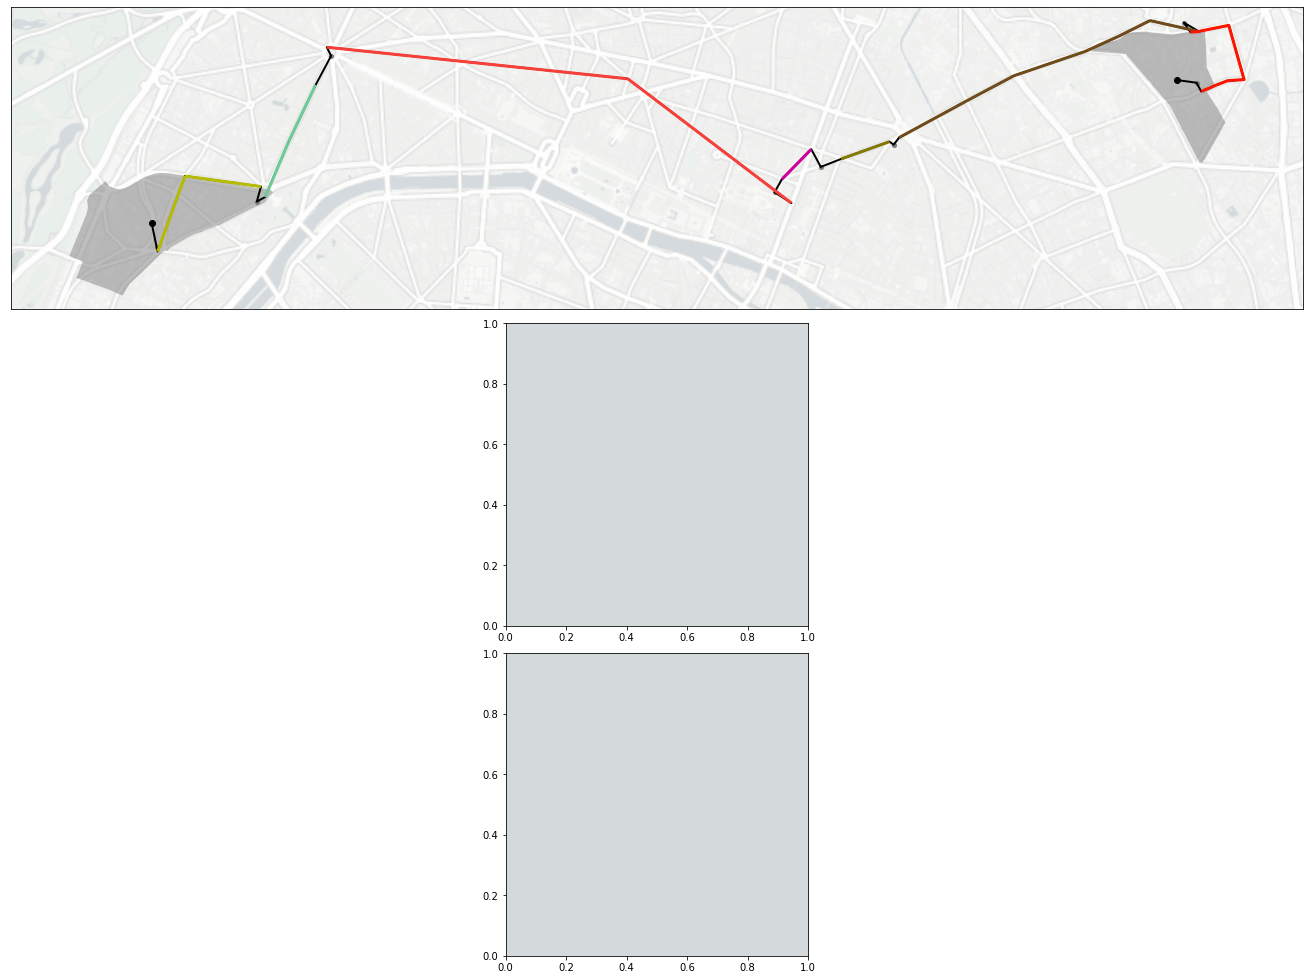

In [12]:
tc.links['color'] = '#' + tc.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = tc.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', 
)

# END